Financial Institutions play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. Historical data are provided on 250,000 borrowers. The goal of this competition is to build a model that borrowers can use to help make the best financial decisions. Hence, improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.

0 : Not deliquent ; 1: Deliquency
(Kaggle Challenge)

Import the libraries

In [ ]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter  #count the key-value pairs in an object

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
#from sklearn.feature_selection import SelectFromModel, SelectKBest
#from sklearn.pipeline import make_pipeline


#sns.set(style='white', context='notebook', palette='deep')
#pd.options.display.max_columns = 100


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
relative_path = '/content/drive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
train_dataset = pd.read_csv('/content/drive/My Drive/cs-training.csv')
test_dataset = pd.read_csv('/content/drive/My Drive/cs-test.csv')
train_dataset = train_dataset.rename(columns={'Unnamed: 0': 'serial'})
test_dataset = test_dataset.rename(columns={'Unnamed: 0': 'serial'})

In [ ]:
train_dataset.shape, test_dataset.shape

((150000, 12), (101503, 12))

Data Exploration/ Preprocessing

In [ ]:
train_dataset.set_index('serial')
train_dataset.head()

,serial,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
train_dataset[train_dataset['SeriousDlqin2yrs'] == 0].count()

serial                                  139974
SeriousDlqin2yrs                        139974
RevolvingUtilizationOfUnsecuredLines    139974
age                                     139974
NumberOfTime30-59DaysPastDueNotWorse    139974
DebtRatio                               139974
MonthlyIncome                           111912
NumberOfOpenCreditLinesAndLoans         139974
NumberOfTimes90DaysLate                 139974
NumberRealEstateLoansOrLines            139974
NumberOfTime60-89DaysPastDueNotWorse    139974
NumberOfDependents                      136229
dtype: int64

In [ ]:
train_dataset.describe().T
#to check if our dataset is balanced, we look at the mean for SeriousDlqin2yrs feature, 0.066

,count,mean,std,min,25%,50%,75%,max
serial,150000.0,75000.500000,43301.414527,1.0,37500.750000,75000.500000,112500.250000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0


In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   serial                                150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [ ]:
train_dataset.isnull().sum()   #%

serial                                      0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

SeriousDlqin2yrs is the target variable (label), it is binary.

The training set contains 150,000 observations of 11 features and 1 label.

All of our features are numerical in nature.

NumberOfDependents and MonthlyIncome contain NaN values, we also suspect that other variables contains errors (Age).

In [ ]:
test_dataset.isnull().sum()

serial                                       0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

How is our target distributed?

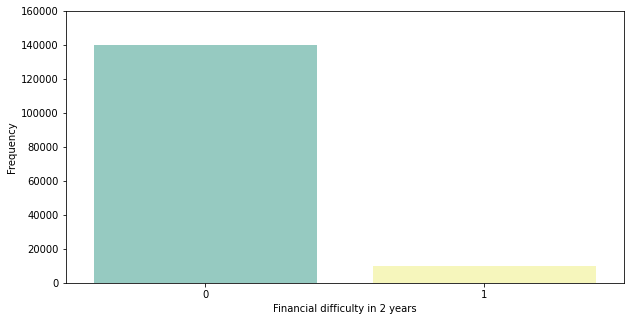

In [ ]:
ax = sns.countplot(x = train_dataset.SeriousDlqin2yrs ,palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel('Financial difficulty in 2 years')
ax.set_ylabel('Frequency')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

plt.show()

From the above, we can see that the distribution of our target variable is very skewed.

In [ ]:
# Lets check for outliers in the dataset
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(train_dataset,2,["RevolvingUtilizationOfUnsecuredLines",
                                            "age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "DebtRatio",
                                            "MonthlyIncome",
                                            "NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "serial",
                                            "NumberOfDependents"])

In [ ]:
train_dataset.loc[Outliers_to_drop]

,serial,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
900,901,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,920,1,1.362142,73,1,274.000000,NaN,2,3,0,1,NaN
1958,1959,0,1.634551,28,0,151.000000,NaN,1,3,0,2,0.0
4852,4853,0,1.566866,46,2,0.104983,6000.0,3,2,0,0,0.0
5956,5957,0,2.237856,60,6,2597.000000,1.0,16,1,2,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117338,117339,1,0.960692,42,0,1.241580,3770.0,29,1,2,1,3.0
126682,126683,1,0.344297,38,0,1.789158,4500.0,23,14,11,1,0.0
129570,129571,0,0.075067,58,0,0.298925,17388.0,24,0,6,1,0.0
5833,5834,1,0.917527,44,0,1.852144,3800.0,13,1,7,1,1.0


We detected 3527 outliers in the training set, which represents 2.53% of our training data. We will drop these outliers.

In [ ]:
train_dataset = train_dataset.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
#merge the datasets
train_dataset_len = len(train_dataset)
dataset =  pd.concat(objs=[train_dataset, test_dataset], axis=0).reset_index(drop=True)

In [ ]:
dataset.shape

(247976, 12)

In [ ]:
dataset = dataset.rename(columns={'serial': 'serial',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

train_dataset = train_dataset.rename(columns={'serial': 'serial',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

test_dataset = test_dataset.rename(columns={'serial': 'serial',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

Exploring Variables

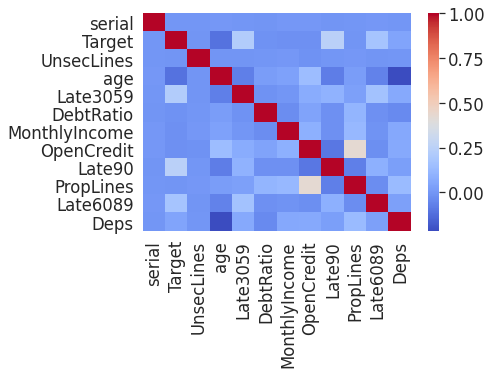

In [ ]:
# Correlation matrix
g = sns.heatmap(train_dataset.corr(),annot=False, fmt = ".2f", cmap = "coolwarm")

We can see that the Target has the highest correlation with age, previous late payments, and the number of dependants.

In [ ]:
#UInsecuredLines
dataset.UnsecLines.describe()

count    247976.000000
mean          5.678007
std         229.111400
min           0.000000
25%           0.029372
50%           0.148802
75%           0.544452
max       50708.000000
Name: UnsecLines, dtype: float64

In [ ]:
dataset.UnsecLines = pd.qcut(dataset.UnsecLines.values, 5).codes

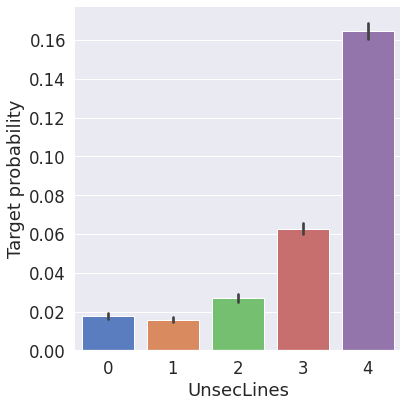

In [ ]:
# Explore UnsecLines feature vs Target
g  = sns.factorplot(x="UnsecLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

We can that there is an almost exponential relationship between this variable and our target

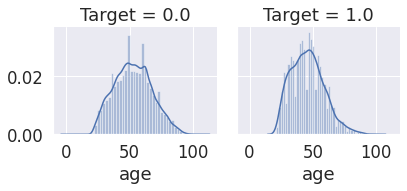

In [ ]:
# Explore Age vs Target
g = sns.FacetGrid(dataset, col='Target')
g = g.map(sns.distplot, "age")

In [ ]:
dataset.age = pd.qcut(dataset.age.values, 5).codes

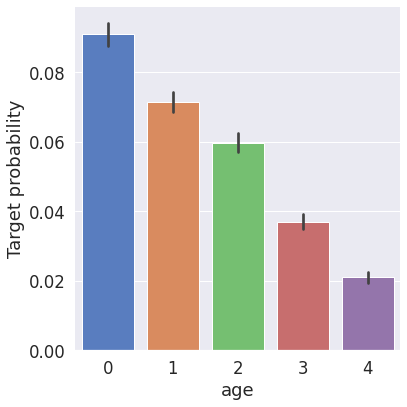

In [ ]:
# Explore age feature vs Target
g  = sns.factorplot(x="age",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")


We can see that age has an inverse relationship to default risk

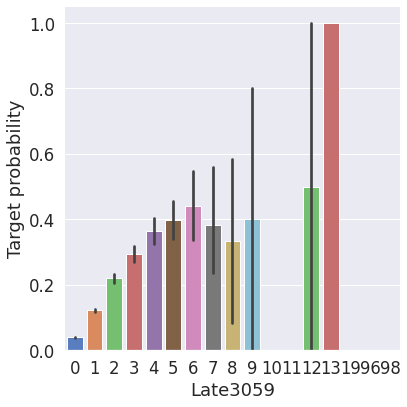

In [ ]:
# Explore Late3059 feature vs Target
g  = sns.factorplot(x="Late3059",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
for i in range(len(dataset)):
    if dataset.Late3059[i] >= 6:
        dataset.Late3059[i] = 6

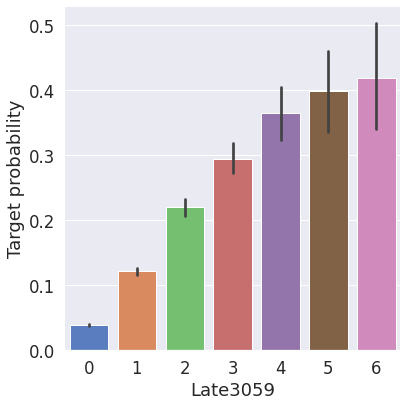

In [ ]:
# Explore Late3059 feature vs Target
g  = sns.factorplot(x="Late3059",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")


Due to very high standard deviations we decided to group customers who have 6 or more late payments together. We can see that this has boosted the predictive capacity and reduced the variance of Late3059

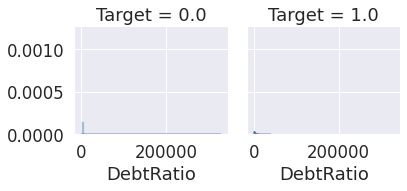

In [ ]:
# Explore DebtRatio vs Target
g = sns.FacetGrid(dataset, col='Target')
g = g.map(sns.distplot, "DebtRatio")

In [ ]:
dataset.DebtRatio = pd.qcut(dataset.DebtRatio.values, 5).codes

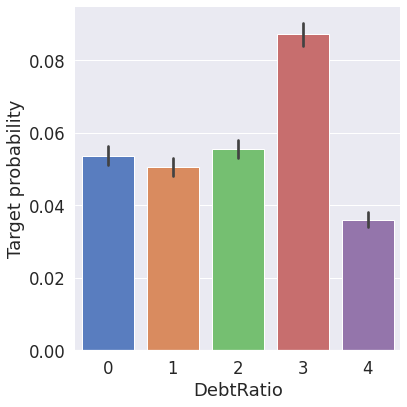

In [ ]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="DebtRatio",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
#Exploring MonthlyIncome
dataset.MonthlyIncome.isnull().sum()

48352

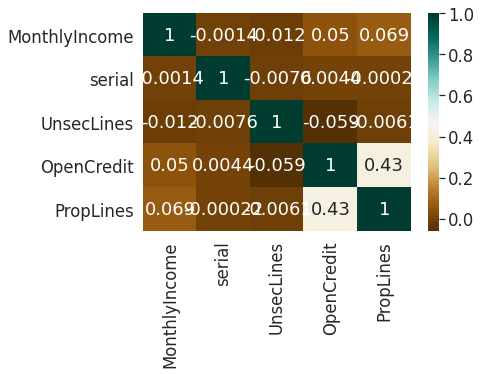

In [ ]:
g = sns.heatmap(dataset[["MonthlyIncome","serial","UnsecLines","OpenCredit","PropLines"]].corr(),cmap="BrBG",annot=True)

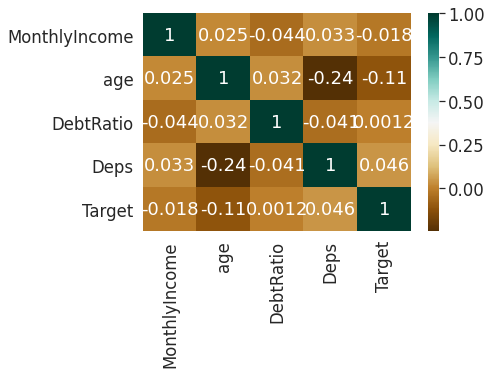

In [ ]:
g = sns.heatmap(dataset[["MonthlyIncome","age","DebtRatio","Deps","Target"]].corr(),cmap="BrBG",annot=True)

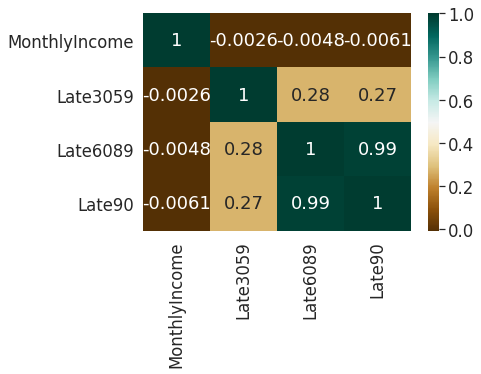

In [ ]:
g = sns.heatmap(dataset[["MonthlyIncome","Late3059","Late6089","Late90"]].corr(),cmap="BrBG",annot=True)

We can see that MonthlyIncome has no strong correlation with any other variable so we cannot accurately estimate the NaN values. Thus, we will fill the NaN with the median value

In [ ]:
dataset.MonthlyIncome.median()

5414.0

In [ ]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset.MonthlyIncome = dataset.MonthlyIncome.fillna(dataset.MonthlyIncome.median())

In [ ]:
dataset.MonthlyIncome = pd.qcut(dataset.MonthlyIncome.values, 5).codes

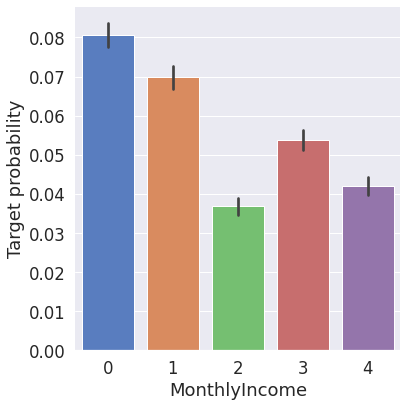

In [ ]:
# Explore MonthlyIncome feature quantiles vs Target
g  = sns.factorplot(x="MonthlyIncome",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
#Exploring OpenCredit
dataset.OpenCredit.describe()

count    247976.000000
mean          8.457516
std           5.109915
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          85.000000
Name: OpenCredit, dtype: float64

In [ ]:
dataset.OpenCredit = pd.qcut(dataset.OpenCredit.values, 5).codes

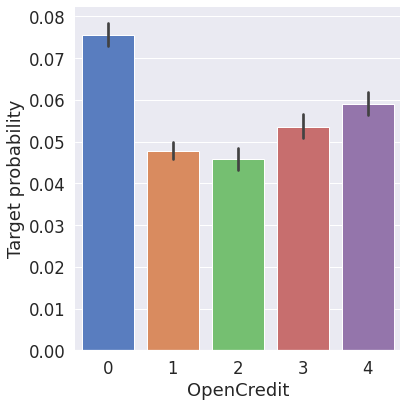

In [ ]:
# Explore OpenCredit feature vs Target
g  = sns.factorplot(x="OpenCredit",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
# Explore Late90 feature vs Target
dataset.Late90.describe()

count    247976.000000
mean          0.156894
std           2.906148
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: Late90, dtype: float64

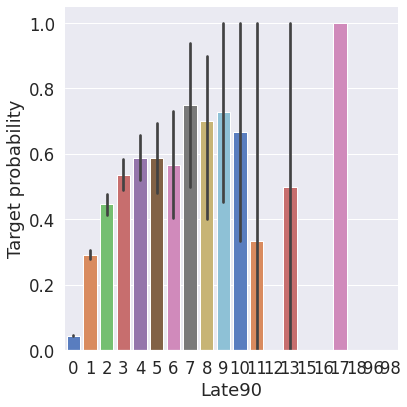

In [ ]:
# Explore Late90 vs Target
g  = sns.factorplot(x="Late90",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
for i in range(len(dataset)):
    if dataset.Late90[i] >= 5:
        dataset.Late90[i] = 5

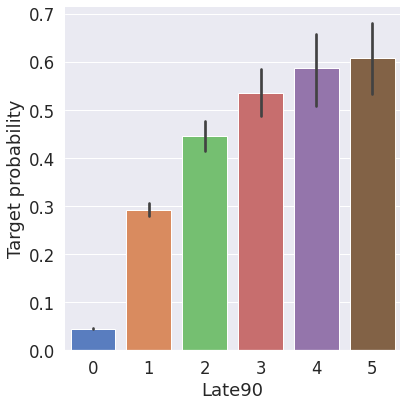

In [ ]:
# Explore Late90 feature quantiles vs Target
g  = sns.factorplot(x="Late90",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
#Explore Proplines
dataset.PropLines.describe()

count    247976.000000
mean          1.013703
std           1.092993
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          37.000000
Name: PropLines, dtype: float64

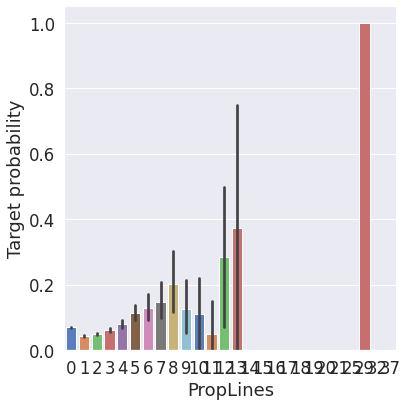

In [ ]:
# Explore Proplines feature vs Target
g  = sns.factorplot(x="PropLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
for i in range(len(dataset)):
    if dataset.PropLines[i] >= 6:
        dataset.PropLines[i] = 6

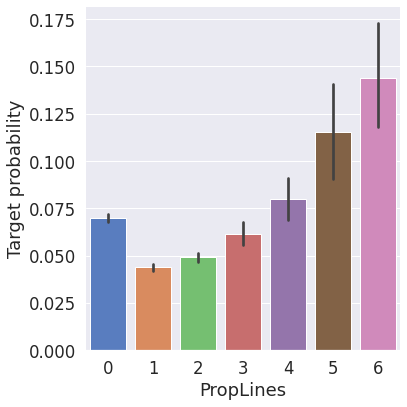

In [ ]:
# Explore Proplines feature vs Target
g  = sns.factorplot(x="PropLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

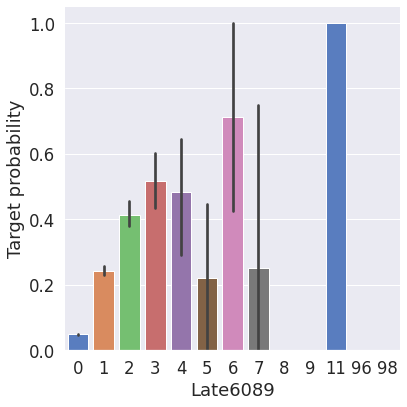

In [ ]:
# Explore Late6089 feature quantiles vs Target
g  = sns.factorplot(x="Late6089",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
for i in range(len(dataset)):
    if dataset.Late6089[i] >= 3:
        dataset.Late6089[i] = 3

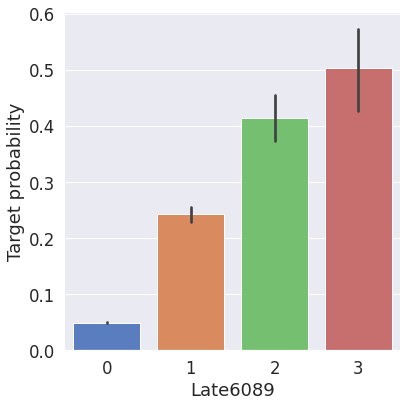

In [ ]:
# Explore Late6089 feature quantiles vs Target
g  = sns.factorplot(x="Late6089",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
#Exploring Deps
dataset.Deps.describe()

count    241584.000000
mean          0.761561
std           1.123201
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          43.000000
Name: Deps, dtype: float64

In [ ]:
dataset.Deps = dataset.Deps.fillna(dataset.Deps.median())

In [ ]:
dataset.Deps.isnull().sum()

0

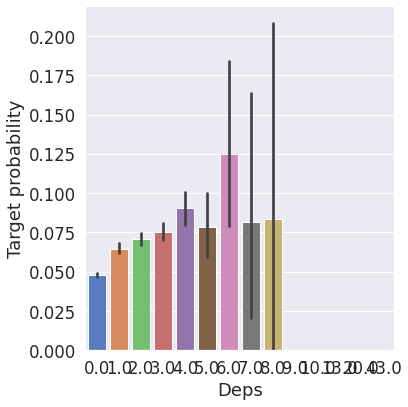

In [ ]:
# Explore Deps feature quantiles vs Target
g  = sns.factorplot(x="Deps",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
for i in range(len(dataset)):
    if dataset.Deps[i] >= 4:
        dataset.Deps[i] = 4

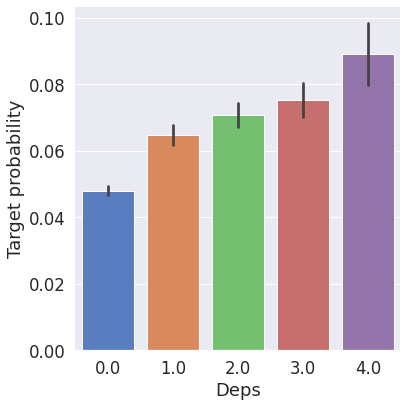

In [ ]:
# Explore Deps feature quantiles vs Target
g  = sns.factorplot(x="Deps",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [ ]:
#Final NAN chaeck
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247976 entries, 0 to 247975
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   serial         247976 non-null  int64  
 1   Target         146473 non-null  float64
 2   UnsecLines     247976 non-null  int8   
 3   age            247976 non-null  int8   
 4   Late3059       247976 non-null  int64  
 5   DebtRatio      247976 non-null  int8   
 6   MonthlyIncome  247976 non-null  int8   
 7   OpenCredit     247976 non-null  int8   
 8   Late90         247976 non-null  int64  
 9   PropLines      247976 non-null  int64  
 10  Late6089       247976 non-null  int64  
 11  Deps           247976 non-null  float64
dtypes: float64(2), int64(5), int8(5)
memory usage: 14.4 MB


In [ ]:
dataset.head()

,serial,Target,UnsecLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps
0,1,1.0,4,1,2,3,4,4,0,6,0,2.0
1,2,0.0,4,1,0,0,0,0,0,0,0,1.0
2,3,0.0,3,0,1,0,0,0,1,0,0,0.0
3,4,0.0,2,0,0,0,0,1,0,0,0,0.0
4,5,0.0,4,2,1,0,4,1,0,1,0,0.0


In [ ]:
#Buidling dummy/binary variables
dataset = pd.get_dummies(dataset, columns = ["UnsecLines"], prefix="UnsecLines")
dataset = pd.get_dummies(dataset, columns = ["age"], prefix="age")
dataset = pd.get_dummies(dataset, columns = ["Late3059"], prefix="Late3059")
dataset = pd.get_dummies(dataset, columns = ["DebtRatio"], prefix="DebtRatio")
dataset = pd.get_dummies(dataset, columns = ["MonthlyIncome"], prefix="MonthlyIncome")
dataset = pd.get_dummies(dataset, columns = ["OpenCredit"], prefix="OpenCredit")
dataset = pd.get_dummies(dataset, columns = ["Late90"], prefix="Late90")
dataset = pd.get_dummies(dataset, columns = ["PropLines"], prefix="PropLines")
dataset = pd.get_dummies(dataset, columns = ["Late6089"], prefix="Late6089")
dataset = pd.get_dummies(dataset, columns = ["Deps"], prefix="Deps")

In [ ]:
dataset.head()

,serial,Target,UnsecLines_0,UnsecLines_1,UnsecLines_2,UnsecLines_3,UnsecLines_4,age_0,age_1,age_2,age_3,age_4,Late3059_0,Late3059_1,Late3059_2,Late3059_3,Late3059_4,Late3059_5,Late3059_6,DebtRatio_0,DebtRatio_1,DebtRatio_2,DebtRatio_3,DebtRatio_4,MonthlyIncome_0,MonthlyIncome_1,MonthlyIncome_2,MonthlyIncome_3,MonthlyIncome_4,OpenCredit_0,OpenCredit_1,OpenCredit_2,OpenCredit_3,OpenCredit_4,Late90_0,Late90_1,Late90_2,Late90_3,Late90_4,Late90_5,PropLines_0,PropLines_1,PropLines_2,PropLines_3,PropLines_4,PropLines_5,PropLines_6,Late6089_0,Late6089_1,Late6089_2,Late6089_3,Deps_0.0,Deps_1.0,Deps_2.0,Deps_3.0,Deps_4.0
0,1,1.0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
1,2,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,3,0.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,4,0.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,5,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
dataset.shape

(247976, 56)

Building Our Credit Scoring Model

In [ ]:
train_dataset = dataset[:train_dataset_len]
test_dataset = dataset[train_dataset_len:]
test_dataset.drop(labels=["Target"],axis = 1,inplace=True)
test_dataset.head() 

,serial,UnsecLines_0,UnsecLines_1,UnsecLines_2,UnsecLines_3,UnsecLines_4,age_0,age_1,age_2,age_3,age_4,Late3059_0,Late3059_1,Late3059_2,Late3059_3,Late3059_4,Late3059_5,Late3059_6,DebtRatio_0,DebtRatio_1,DebtRatio_2,DebtRatio_3,DebtRatio_4,MonthlyIncome_0,MonthlyIncome_1,MonthlyIncome_2,MonthlyIncome_3,MonthlyIncome_4,OpenCredit_0,OpenCredit_1,OpenCredit_2,OpenCredit_3,OpenCredit_4,Late90_0,Late90_1,Late90_2,Late90_3,Late90_4,Late90_5,PropLines_0,PropLines_1,PropLines_2,PropLines_3,PropLines_4,PropLines_5,PropLines_6,Late6089_0,Late6089_1,Late6089_2,Late6089_3,Deps_0.0,Deps_1.0,Deps_2.0,Deps_3.0,Deps_4.0
146473,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
146474,2,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
146475,3,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
146476,4,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
146477,5,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [ ]:
test_dataset.shape, train_dataset.shape

((101503, 55), (146473, 56))

In [ ]:
## Separate train features and label 

train_dataset["Target"] = train_dataset["Target"].astype(int)
y_train_dataset = train_dataset["Target"]
X_train_dataset = train_dataset.drop(labels = ["Target", "serial"],axis = 1)

In [ ]:
##Split training dataset to train and valuidation datasets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_dataset,
                                                      y_train_dataset, 
                                                      test_size=0.30, 
                                                      random_state=123)

print(X_train.shape, X_valid.shape) 

(102531, 54) (43942, 54)


In [ ]:
rfc = RandomForestClassifier(n_estimators=50, max_features='sqrt')
train_fit = rfc.fit(X_train, y_train)

In [ ]:
features = pd.DataFrame()
features['feature'] = X_train_dataset.columns
features['importance'] = rfc.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

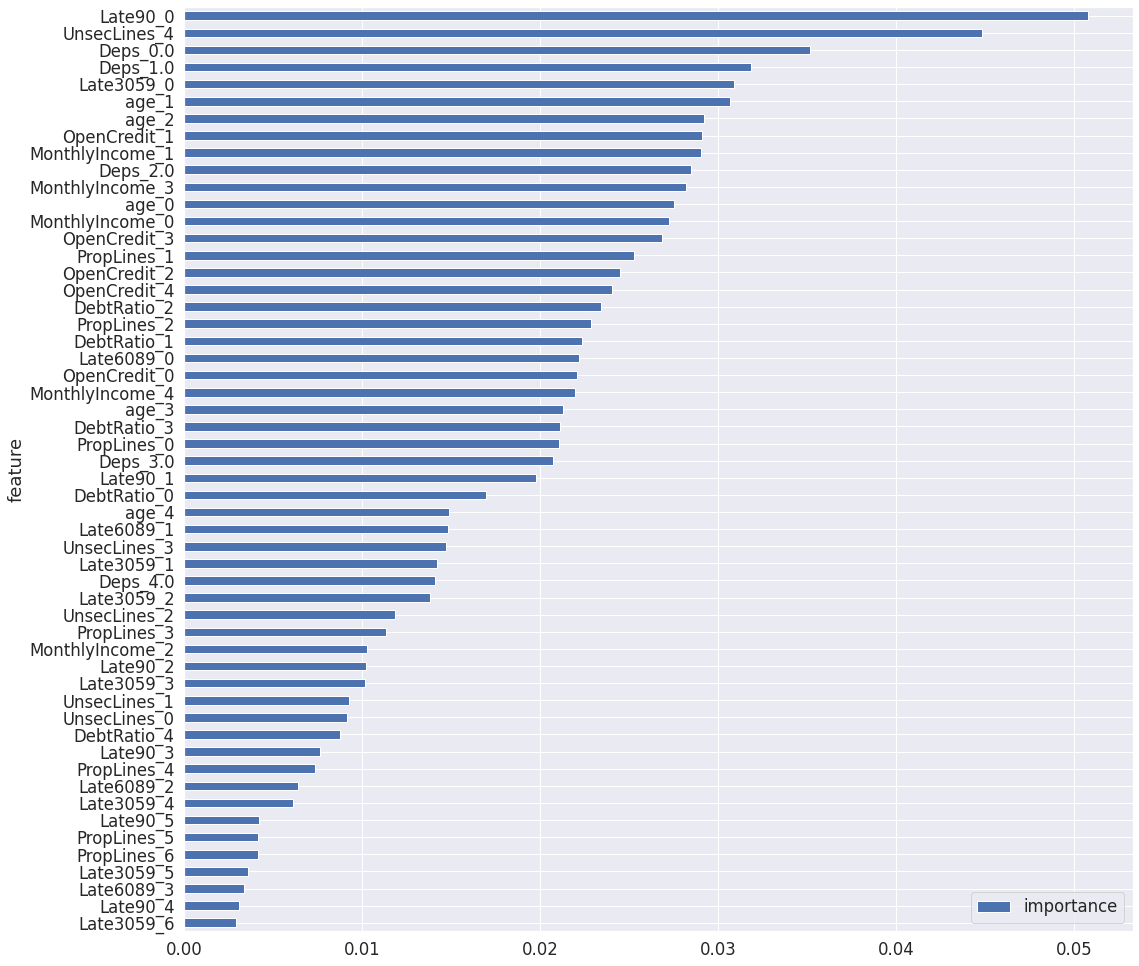

In [ ]:
features.plot(kind='barh', figsize=(17, 17))

Logistic Regression

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create an instance of Logistic Regression Classifier and fit the data.

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Measure classification accuracy over the training/test sets.

In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = log_reg.predict(X_train)
y_valid_pred = log_reg.predict(X_valid)

print("Training Accuracy: {0:.2f}".format(accuracy_score(y_train, y_train_pred)))
print("Validation Accuracy: {0:.2f}".format(accuracy_score(y_valid, y_valid_pred)))

Training Accuracy: 0.94
Validation Accuracy: 0.94


Build a text report showing the main classification metrics including precision, recall, f1-score, and accuracy.

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_valid, y_valid_pred)   #use valid 
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     41449
           1       0.55      0.13      0.21      2493

    accuracy                           0.94     43942
   macro avg       0.75      0.56      0.59     43942
weighted avg       0.93      0.94      0.93     43942



 Compute and plot confusion matrix.

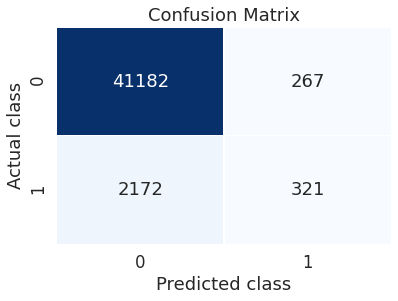

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,4))

cm = confusion_matrix(y_valid, y_valid_pred)    #use valid
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion Matrix");

In [ ]:
results_df = pd.read_csv('/content/drive/My Drive/cs-test.csv')

In [ ]:
results_df = results_df.drop(["RevolvingUtilizationOfUnsecuredLines",
                             "age",
                             "NumberOfTime30-59DaysPastDueNotWorse",
                             "DebtRatio",
                             "MonthlyIncome",
                             "NumberOfOpenCreditLinesAndLoans",
                             "NumberOfTimes90DaysLate",
                             "NumberRealEstateLoansOrLines",
                             "NumberOfTime60-89DaysPastDueNotWorse",
                             "NumberOfDependents"], axis=1)

In [ ]:
DefaultProb = model.predict_proba(test_dataset.drop(columns='serial'))
DefaultProb = DefaultProb[:,1]
results_df.SeriousDlqin2yrs = DefaultProb

results_df = results_df.rename(columns={'serial': 'Id',
                                        'Target': 'Probability'})

NameError: ignored

In [ ]:
results_df.head()

In [ ]:
path = '/content/drive/My Drive/'
results_df.to_csv(path + "CREDIT_SCORE_LOG.csv", index=False)

In [ ]:
results = pd.read_csv(path + 'CREDIT_SCORE_LOG.csv')
results.head(10)

Random Forest Model

In [ ]:
parameters = {'n_estimators': 50, 'random_state' : 20}   #alter
    
model = RandomForestClassifier(**parameters)
model.fit(X_train, y_train)

Test/Predict the Model

In [ ]:
y_train_pred = model.predict(X_train)   
print("Training accuracy is:", accuracy_score(y_train, y_train_pred)) 

y_valid_pred= model.predict(X_valid)   
print("Test accuracy is:",  accuracy_score(y_valid, y_valid_pred))

Improving model

In [ ]:
model = RandomForestClassifier(min_impurity_decrease=0.00001)    # further reduce the min impurity
model.fit(X_train, y_train)  

y_train_pred = model.predict(X_train)   
print("Training accuracy is:", accuracy_score(y_train, y_train_pred))

y_valid_pred = model.predict(X_valid) 
print("Test accuracy is:", accuracy_score(y_valid, y_valid_pred))

Reduction in min impurity decrease improves the validation accuracy at the expense of the training accuracy.

Nonetheless, to find the best combination of hyperparameters, we are going simply train the model on different combinations and pick the best combination of n_estimators and max_features and use.

In [ ]:
def train_for_comb(n_estimators, max_features):
  model = RandomForestClassifier(random_state=1, min_impurity_decrease=0.00001,
                                   n_estimators=n_estimators, max_features = max_features)
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  train_accuracy = accuracy_score(y_train, y_train_pred)
  y_valid_pred =  model.predict(X_valid)
  test_accuracy =  accuracy_score(y_valid, y_valid_pred)   
  return ([train_accuracy, test_accuracy])
 
n_estimators_list = [50,100,200,300,500]
max_features_list = [int(i) for i in np.linspace(1,X_train.shape[1], 10)]

# dictionary to store accuracy scores for each combination   
accuracy_dic ={}

# loop to compute all accuracies
for n_estimators in n_estimators_list:
    for max_features in max_features_list:
      x = train_for_comb(n_estimators, max_features)
      accuracy_dic[(n_estimators, max_features)] = x
        
curr_max = 0
for i,j in accuracy_dic:
  (train, test) = accuracy_dic[(i,j)]
  if min(train, test) > curr_max:
    curr_max = min(train, test)

Optionally, instead of manually looking for the best we can look for the best split. Use GridSearchCV to find it

In [ ]:
from sklearn.model_selection import GridSearchCV

n_estimators = [int(i) for i in np.linspace(50, 1000, )]
total_features = X_train.shape[1]
max_features = [int(i) for i in np.linspace(1, total_features, 10)]
tuned_parameters = {
    'n_estimators': n_estimators,
    'max_features': max_features
} 

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=tuned_parameters, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

print('The best combination:', grid_search.best_params_)

y_valid_pred = grid_search.predict(X_valid)
print('Test accuracy is:', accuracy_score(y_valid, y_valid_pred))

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

# Fit the data
mlp.fit(X_train, y_train)
mlp.fit(X_valid, y_valid)

print(mlp.score(X_train, y_train))
print(mlp.score(X_valid, y_valid))

Model Performance/Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
print('Training Accuracy:', accuracy_score(y_train_pred, y_train))
print('Validation Accuracy:', accuracy_score(y_valid_pred, y_valid))

Model Scores/Results

In [ ]:
results_df = pd.read_csv('/content/drive/My Drive/cs-test.csv')

In [ ]:
results_df = results_df.drop(["RevolvingUtilizationOfUnsecuredLines",
                             "age",
                             "NumberOfTime30-59DaysPastDueNotWorse",
                             "DebtRatio",
                             "MonthlyIncome",
                             "NumberOfOpenCreditLinesAndLoans",
                             "NumberOfTimes90DaysLate",
                             "NumberRealEstateLoansOrLines",
                             "NumberOfTime60-89DaysPastDueNotWorse",
                             "NumberOfDependents"], axis=1)

In [ ]:
DefaultProb = model.predict_proba(test_dataset.drop(columns='serial'))
DefaultProb = DefaultProb[:,1]
results_df.SeriousDlqin2yrs = DefaultProb

results_df = results_df.rename(columns={'serial': 'Id',
                                        'Target': 'Probability'})

In [ ]:
results_df.head()

In [ ]:
path = '/content/drive/My Drive/'
results_df.to_csv(path + "CREDIT_SCORE.csv", index=False)

In [ ]:
results = pd.read_csv(path + 'CREDIT_SCORE.csv')
results.head(10)

Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()  
model.fit(X_train, y_train)

Use the fitted model to predict training data and check accuracy.

In [ ]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train)
print("Training accuracy is:", accuracy_score(y_train_pred, y_train))

Our algorithm has an excellent accuracy on training data.

Predict now test data and compute accuracy. Compare training accuracy and test accuracy.

In [ ]:
y_valid_pred =  model.predict(X_valid)
print("Test accuracy is:",accuracy_score(y_valid_pred, y_valid))

Improving the model

In [ ]:
def train_pruned_tree(min_decrease):
  model = DecisionTreeClassifier(random_state=1, min_impurity_decrease = min_decrease) 
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)  
  train_accuracy = accuracy_score(y_train, y_train_pred) 
  y_valid_pred = model.predict(X_valid)
  test_accuracy = accuracy_score(y_valid, y_valid_pred)  
  return ([train_accuracy, test_accuracy])

train_pruned_tree(0.001)

Here, we see that with prunning we gain some test accuracy but at a loss of a bit of the training accuracy.

We can also train multiple models using varying values of min_decrease in the function and plot two lines: one for training accuracy scores and another for test accuracy scores.

In [ ]:
min_decrease_list = 10**(np.array(range(10, -100, -5))/10)
x = [train_pruned_tree(min_decrease) for min_decrease in min_decrease_list]
y = np.array(x)
# get train and test accuracy scores for all values of min_decrease 
train_accuracies, test_accuracies = y[:,0], y[:,1] 
plt.plot(np.log10(min_decrease_list), train_accuracies, )
plt.plot(np.log10(min_decrease_list), test_accuracies )
# plot lines 
plt.legend('Train', 'Test')
plt.xlabel('Logarithmic Scale of min_decrease')
plt.ylabel('Accuracy Scores')